In [1]:
import logit
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import defaultdict
import re

import importlib
importlib.reload(logit)



<module 'logit' from '/li_zhengdao/github/logvis/logit.py'>

loaded previous DB!!


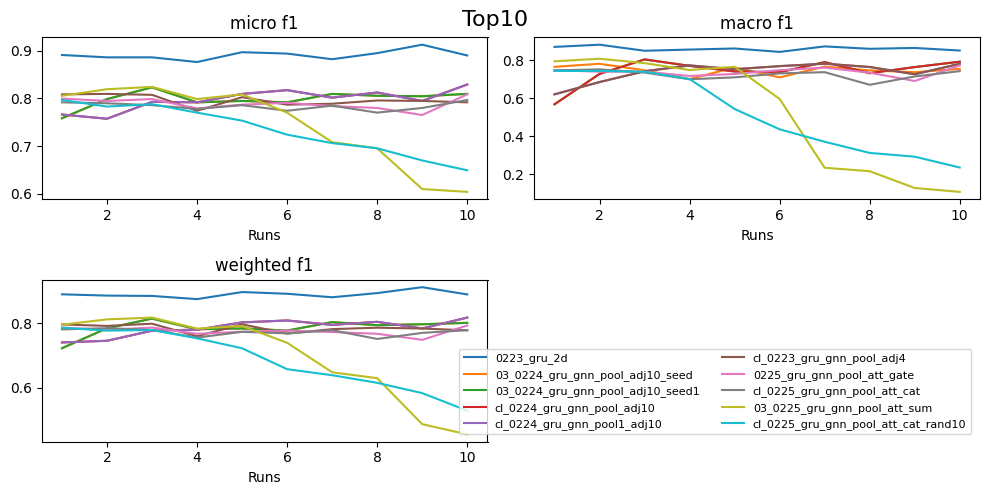

In [2]:
def fill_empty(l, pad=0):
    len_l = len(l)
    if pad == "mean":
        pad = np.array(l).mean()
    for _ in range(logit.MAX_RUNS-len_l):
        l.append(pad)
    

def exclude_log_name(name):
    patterns = []
    without_list = ['seizure', 'freq', 'shared','1d']
    and_with_list = []
    or_with_list = ['0223', '0224','0225']
    
    for pt in patterns:
        if re.match(pt, name) is not None:
            return False
    
    for s in without_list:
        if s in name:
            return True
    
    for s in and_with_list:
        if s not in name:
            return True
        
    for s in or_with_list:
        if s in name:
            return False
        
    return True
    
def exclude_log_data(data):
    d = np.array(data)
    if np.min(d) > 0.1 and np.min(d) < 0.6:
        return True
    return False


def skip(name, data):
    # skip = exclude_log_data(data)
    skip = exclude_log_data(data) or exclude_log_name(name)
    return skip

def topk_data(datas, K=5):
    topk = []
    top_mean = dict()
    for i, ms in enumerate(datas):
        for file_name, values in ms.items():
            top_mean[i] = np.array(values).mean()
    
    sorted_data = sorted(top_mean.items(), key=lambda x: x[1], reverse=True)
    K = len(datas) if len(datas) < K else K
    for i in range(K):
        id = sorted_data[i][0]
        topk.append(datas[id])
    
    return topk

def filter_data(db, topK=5):
    datas = []
    for file_name, v in db.items():
        data = dict()
        data[logit.m1] = v[logit.m1]
        data[logit.m2] = v[logit.m2]
        data[logit.m3] = v[logit.m3]
        if skip(file_name, data[logit.m1]):
            continue
        datas.append({file_name:data})
    
    metrics = defaultdict(list)
    for d in datas:
        for file_name, data in d.items():
            for m_name, v in data.items():
                metrics[m_name].append({file_name:v})
    # print(metrics)
    K = topK
    for m_name, data in metrics.items():
        K = len(data) if len(data) < K else topK
        topk = topk_data(data, K=K)
        for m in topk:
            for _, d in m.items():
                fill_empty(d, pad="mean")
        metrics[m_name] = topk
    return metrics, K
    
def compare_sets(ll):
    for i in range(1, len(ll)):
        if ll[0] != ll[i]:
            return True
    return False
    
    
def plot_metrics(db, topK=5):
    
    xs = list(range(1, logit.MAX_RUNS+1))
    top_k, K = filter_data(db, topK)
    
    fig = plt.figure(figsize=(10,5), dpi=100)
    fig.patch.set_facecolor('white')
    
    legend_labels = []
    for i, (m, d) in enumerate(top_k.items()):
        ax = fig.add_subplot(2, 2, i+1)
        legends = []
        yss = []
        for metrics in d:
            for k, v in metrics.items():
                legends.append(k)
                yss.append(v)
                if k == '0219_1d_strid2_8out_2d_512hid':
                    print(v)
        legend_labels.append(set(legends))
        for ys in yss:
            ax.plot(xs, ys)
        if len(yss) < 6:
            ax.legend(legends, ncol=2, fontsize=6, title_fontsize=3,loc='lower left')
        # ax.legend(legends, bbox_to_anchor=(0.5, -0.5), ncol=2, fontsize=6,title_fontsize=3,loc='lower center')
        ax.set_title(f'{m}')
        ax.set_xlabel('Runs')
    
    # compare legends:
    if compare_sets(legend_labels):
        print('Warning: legends not same!!!!!!!!!!!!!!!!!!!!!!!!!')
    fig.legend(legends, ncol=2, bbox_to_anchor=(0.72, 0.12), fontsize=8, loc='lower center')
        
    fig.tight_layout()
    fig.suptitle(f'Top{K}',fontsize=16)
    plt.show()

metrics = logit.load_DB()

plot_metrics(metrics, topK=10)

In [ ]:
# plot box:

